The avg. runtime of `retrive_and_interpolate_data` and save a new dataframe is 6.5s for each entry in the csv

Therefore the runtime of 4160 entries in 2016_AIS.csv is approximately `7.5` hours.

In [ ]:
import pandas as pd
import requests
import numpy as np
from motu_utils.utils_cas import authenticate_CAS_for_URL
from motu_utils.utils_http import open_url
import xarray as xr
from datetime import datetime, timezone, timedelta 
import time
from pathlib import Path
from bs4 import BeautifulSoup
import sys

In [ ]:
# url without variables
base_url = 'http://nrt.cmems-du.eu/motu-web/Motu?action=productdownload&service=GLOBAL_ANALYSIS_FORECAST_WAV_001_027-TDS&product=global-analysis-forecast-wav-001-027'

# utils to convert dates 
str_to_date = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
date_to_str = lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ')

# credentials for the dataset
UN_CMEMS = %env UN_CMEMS
PW_CMEMS = %env PW_CMEMS

In [ ]:
def create_request_url(date, lat, lon):
    """
        creates a valid url to download data from the dataset with using credentials.
        
    Parameters
    ----------
    date : str
        datetime as a string as the format YYYY-mm-ddTHH:MM:SSZ
    lat : str, float
        latitude
    lon : str, float
        longitude
    """
    y_lo=float(lat)
    y_hi=float(lat)
    x_lo=float(lon)
    x_hi=float(lon)
    t_lo=date
    t_hi=date
    url = base_url+'&x_lo={0}&x_hi={1}&y_lo={2}&y_hi={3}&t_lo={4}&t_hi={5}&mode=console'.format(x_lo, x_hi, y_lo, y_hi, t_lo, t_hi)
    return authenticate_CAS_for_URL(url , UN_CMEMS, PW_CMEMS)

In [ ]:
def retrive_and_interpolate_data(date, lat, lon, dataset_temporal_resolution):
    """
        retrive all variables from dataset for a specific timestamp, latitude, longitude concidering
        the temporal resolution of the dataset to calculate interpolated values
    
    Parameters
    ----------
    date : datetime object
        datetime as a date object
    lat : str, float
        latitude
    lon : str, float
        longitude
    dataset_temporal_resolution: int
        the temporal resolution of the dateset (in hours)
    """
    h = date.hour 
    rest = h % dataset_temporal_resolution 
    if rest == 0:
        url = create_request_url(date_to_str(date), lat, lon)
        date = xr.open_dataset(open_url(url).read())
        return np.ravel(date.to_dataframe().reset_index(drop=True).values)
    else:
        nearest_lower = date - timedelta(hours= rest)
        nearest_upper = date + timedelta(hours=dataset_temporal_resolution-rest)
        
        url_lower = create_request_url(date_to_str(nearest_lower), lat, lon)
        url_upper = create_request_url(date_to_str(nearest_upper), lat, lon)
        
        bytes_lower = open_url(url_lower).read()
        bytes_upper = open_url(url_upper).read()
        
        try:
            data_lower = xr.open_dataset(bytes_lower)
            data_upper = xr.open_dataset(bytes_upper) 
        except:
            # print the error tag from html
            print(BeautifulSoup(bytes_lower, 'html.parser').find('p', {"class": "error"}))
            print(BeautifulSoup(bytes_upper, 'html.parser').find('p', {"class": "error"}))
       
      
        v_lower = data_lower.to_dataframe().reset_index(drop=True)
        v_upper = data_upper.to_dataframe().reset_index(drop=True)
    
        # temporal interpolation 
        alpha = rest / dataset_temporal_resolution
        return np.ravel((1- alpha)* v_lower.values + (alpha * v_upper.values))

In [ ]:
def append_enviorment_data(year):
    src_csv_path = Path(str(year),'%s_AIS.csv' % year)
    output_csv_path = Path(str(year),'%s_merged.csv' % year)
    
    # get extracted AIS data and remove index column
    df = pd.read_csv(src_csv_path,parse_dates=['BaseDateTime'], date_parser=str_to_date)
    df.drop(['Unnamed: 0'], axis=1, errors='ignore', inplace=True)
    
    # define new columns for the output datafarme
    cols = list(df.columns) + ['VHM0_WW', 'VMDR_SW2', 'VMDR_SW1','VMDR',  'VTM10', 'VTPK','VPED','VTM02','VMDR_WW','VTM01_SW2','VHM0_SW1','VTM01_SW1','VSDX','VSDY','VHM0','VTM01_WW','VHM0_SW2']
   
    # check if already appended data to resume in case of disconnetion or other errors
    data_list = []
    if Path(output_csv_path).exists():
        data_list = list(pd.read_csv(output_csv_path).drop(['Unnamed: 0'], axis=1, errors='ignore').values)
        print('Resuming download from row %s ' % len(data_list))
        
    # loop over the AIS data starting from the last index, where it has stopped
    last_index = len(data_list)
    for x in df.values[last_index:]:
        date, lat, lon = x[:3]
        env_variables = retrive_and_interpolate_data(date, lat, lon, 3)
        data_list.append(np.concatenate([x, env_variables]))
        pd.DataFrame(data_list, columns=cols).to_csv(output_csv_path)
        last_index+=1
        sys.stdout.write("\rEntry row index: %s/%s" % (last_index, len(df)))
        sys.stdout.flush()
        
    return pd.DataFrame(data_list, columns=cols)

In [ ]:
result = append_enviorment_data(2016)

In [15]:
year = 2016
df = pd.read_csv(Path(str(year),'%s_merged.csv' % year)).drop(['Unnamed: 0'], axis=1, errors='ignore')
df= df[['SOG','VHM0_WW', 'VMDR_SW2', 'VMDR_SW1','VMDR',  'VTM10', 'VTPK','VPED','VTM02','VMDR_WW','VTM01_SW2','VHM0_SW1','VTM01_SW1','VSDX','VSDY','VHM0','VTM01_WW','VHM0_SW2']]
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

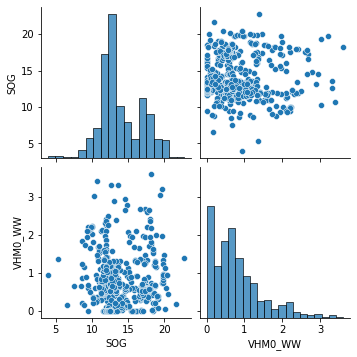

In [19]:
import seaborn as sns
sns.pairplot(df[['SOG','VHM0_WW']])

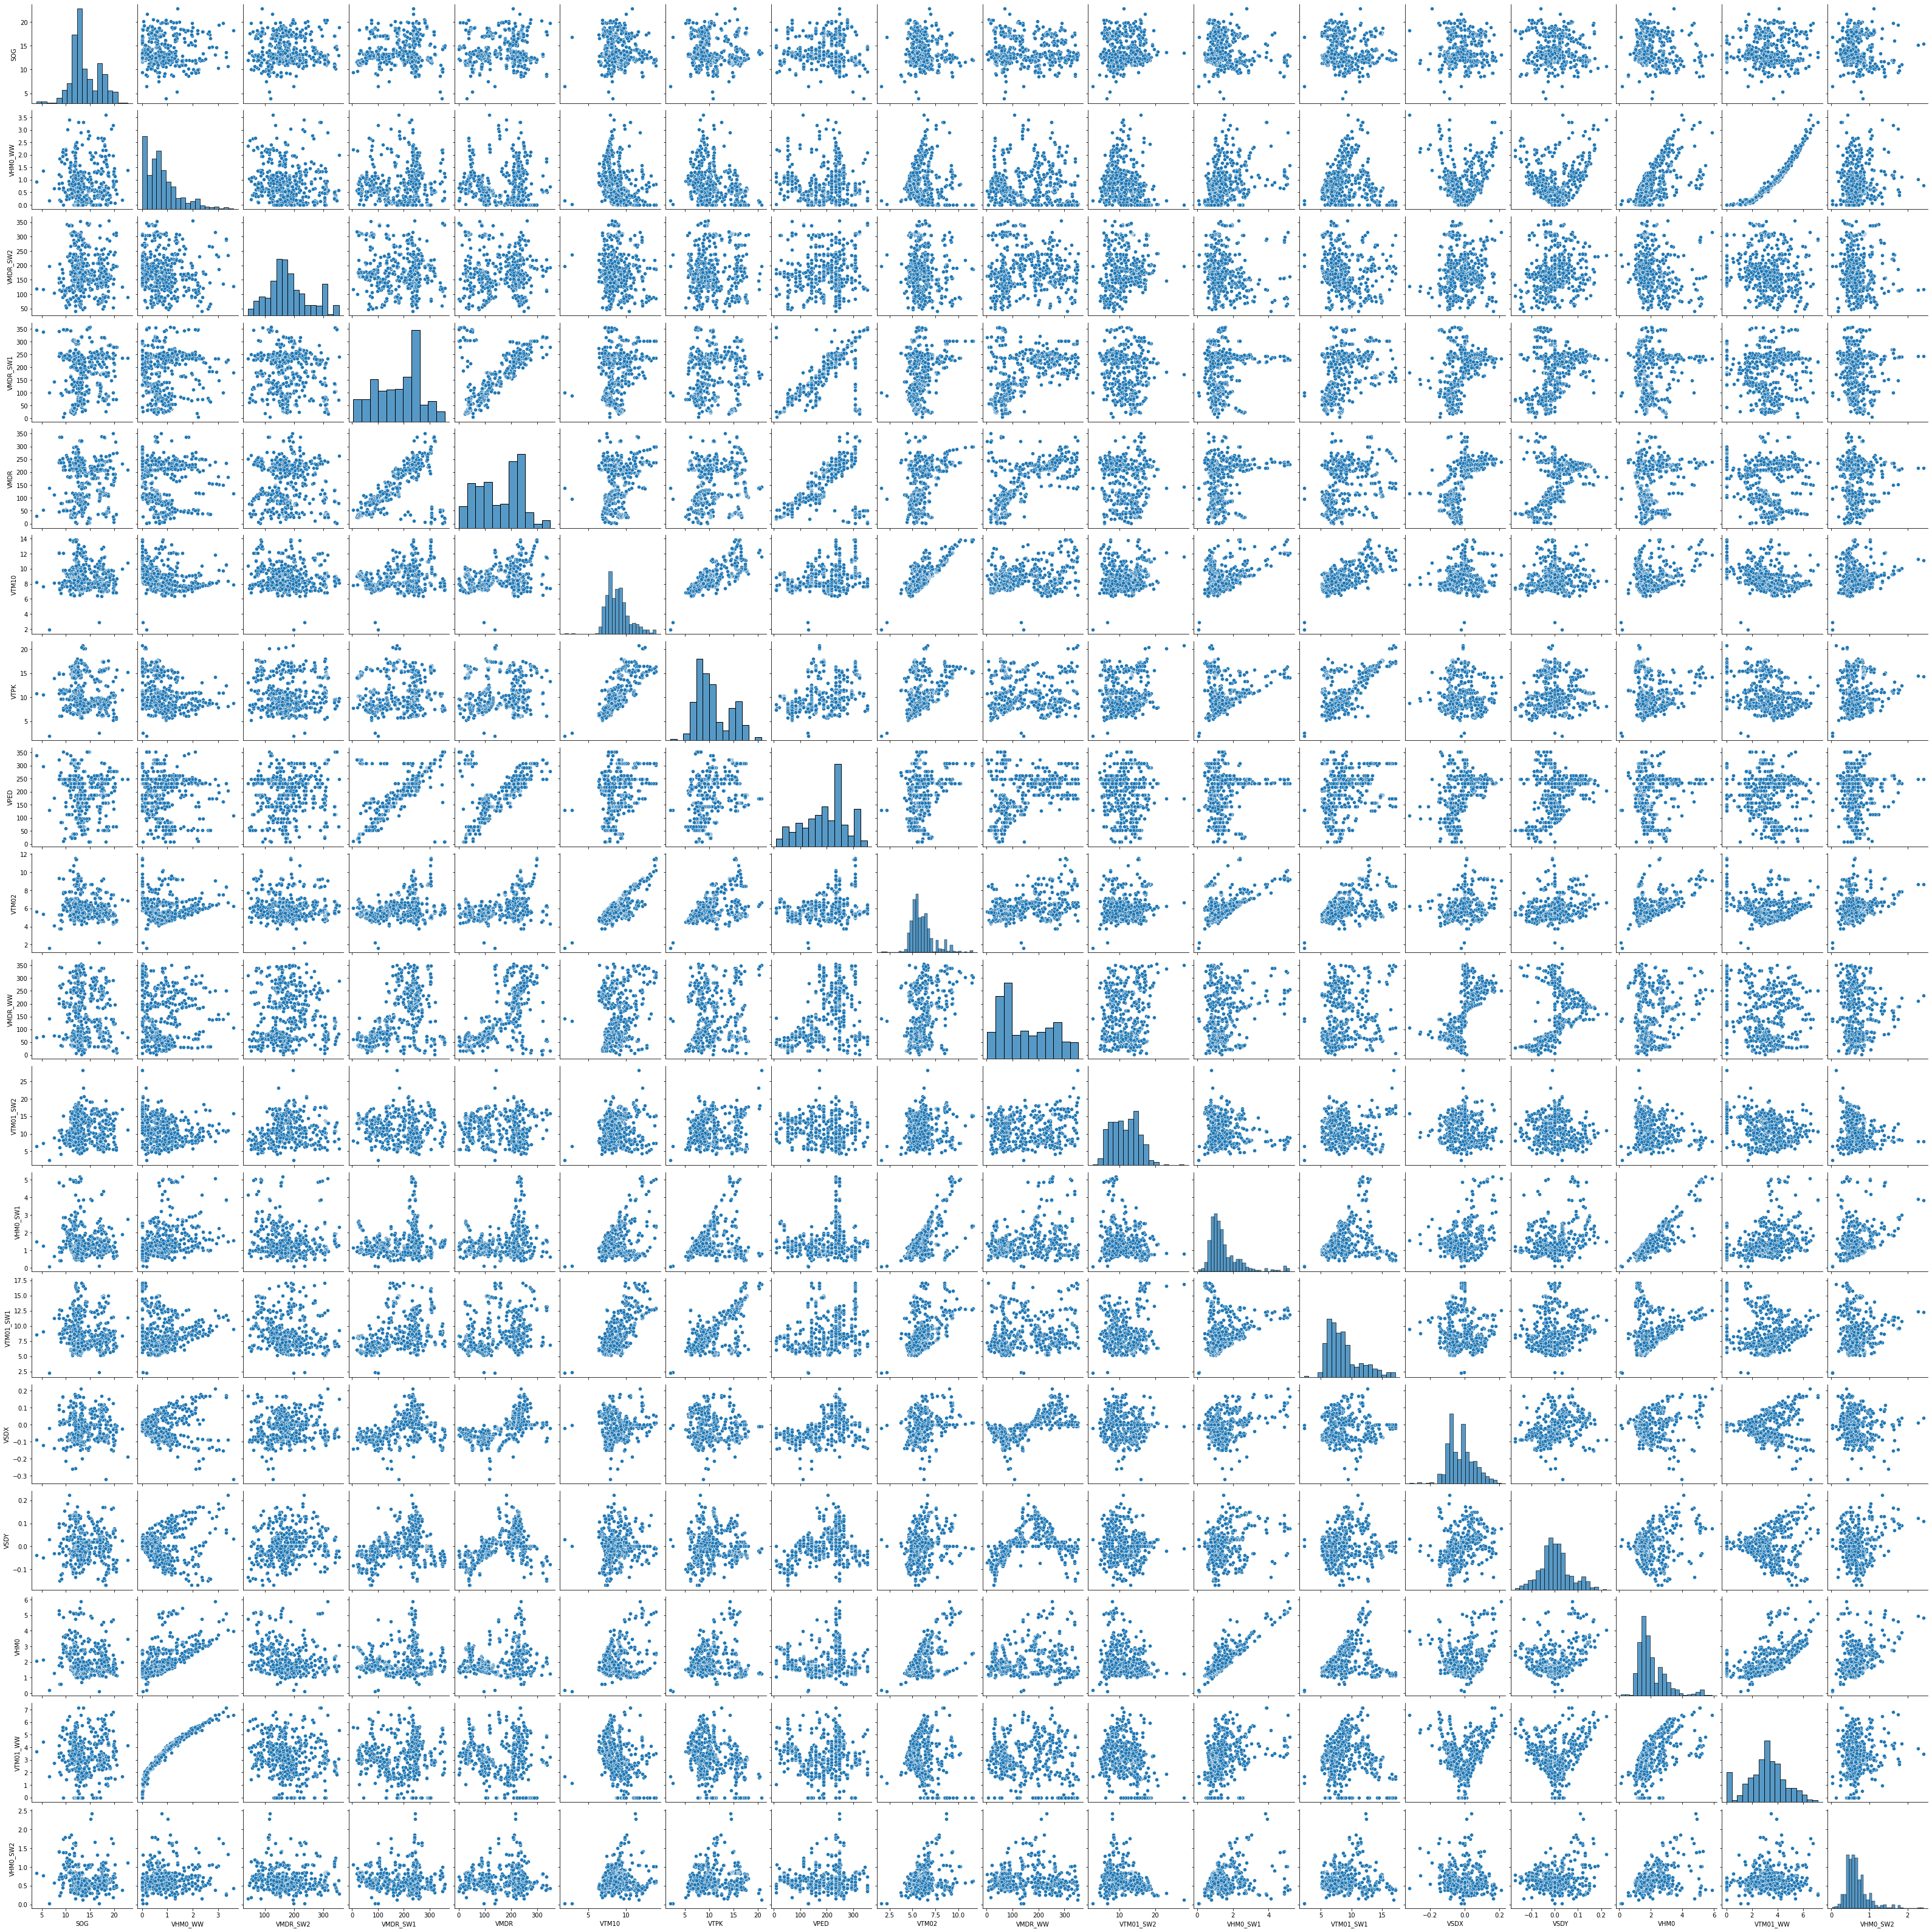

In [20]:
import seaborn as sns
sns.pairplot(df)